In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
file_name = "GOOGL.csv"
dataset = pd.read_csv(file_name)
# dataset.head()
Open_price = dataset['Open']

In [4]:
Open_price_norm = MinMaxScaler().fit_transform(Open_price.values.reshape(-1, 1))

In [5]:
# dataset needs to be restore according to the days for prediction
input_data = []
input_label = []

# choose 10 days stock price for prediction
days = 10

index = 0
while (index + days) < len(Open_price_norm):
        input_data.append(Open_price_norm[index: (index + days)])
        input_label.append(Open_price_norm[index + days])
        index = index + 1
        
# split training, validation and testing data
split_train_index = int(np.ceil(len(input_label) * 0.9))
split_validation_index = int(np.ceil(len(input_label) * 0.95))

x_train = np.array(input_data[:split_train_index])
y_train = np.array(input_label[:split_train_index])

x_validation = np.array(input_data[split_train_index: split_validation_index])
y_validation = np.array(input_label[split_train_index: split_validation_index])

x_test = np.array(input_data[split_validation_index:])
y_test = np.array(input_label[split_validation_index:])

In [6]:
lr = 0.001
batch_size = 64
num_seq = 10
input_size = 1
hidden_layer = 128
epoch = 50

In [7]:
X = tf.placeholder(tf.float32, [None, num_seq, input_size])
Y = tf.placeholder(tf.float32, [None, input_size]) 

In [8]:
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def LSTM(input, output, state):
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    state = state * forget_gate + input_gate * memory_cell
    output = output_gate * tf.tanh(state)
    return state, output

In [10]:
results = []
for i in range(batch_size):
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    for j in range(num_seq):
        batch_state, batch_output = LSTM(tf.reshape(X[i][j], (-1, 1)), batch_output, batch_state)
    results.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [11]:
loss = []
for i in range(len(results)):
    loss.append(tf.losses.mean_squared_error(tf.reshape(Y[i], (-1, 1)), results[i]))      
loss = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init) 
    for i in range(epoch):
        # fetch batch
        index = 0
        while (index + batch_size) < len(x_train):
            x_batch = x_train[index: (index + batch_size)]
            y_batch = y_train[index: (index + batch_size)]
            # run optimization
            sess.run(train_op, feed_dict={X:x_batch, Y:y_batch})
            index = index + batch_size
        # validation
        if i % 5 == 0:
            print('Epoch {}/{}'.format((i + 1), epoch), ' Val_loss: {}'.format(sess.run(loss, feed_dict={X:x_validation, Y:y_validation})))
    save_path = saver.save(sess, 'model.ckpt') 

Epoch 1/50  Val_loss: 0.012787425890564919
Epoch 6/50  Val_loss: 0.007631921675056219
Epoch 11/50  Val_loss: 0.0005824877880513668
Epoch 16/50  Val_loss: 0.0004965348052792251
Epoch 21/50  Val_loss: 0.0004888133844360709
Epoch 26/50  Val_loss: 0.0004878391046077013
Epoch 31/50  Val_loss: 0.0004939990467391908
Epoch 36/50  Val_loss: 0.0004945404944010079
Epoch 41/50  Val_loss: 0.00047235714737325907
Epoch 46/50  Val_loss: 0.00045170291559770703


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model.ckpt


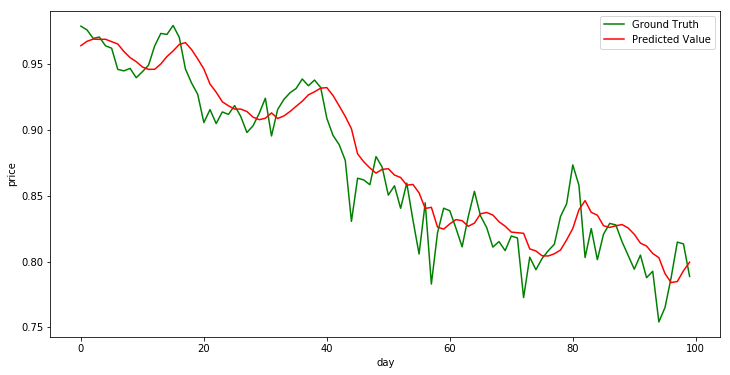

In [13]:
prices = []
index = 0
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    while (index + batch_size) < len(x_test):
        temp = sess.run(results, feed_dict={X:x_test[index: (index + batch_size)]})
        index = index + batch_size
        prices.append(temp)
    prices = np.squeeze(np.asarray(prices)).flatten()

    plt.figure(figsize=(12,6))
    plt.plot(range(100),y_test[0:100],color='green')
    plt.plot(range(100),prices[0:100],color='red')
    plt.legend(['Ground Truth','Predicted Value'])
    plt.xlabel('day')
    plt.ylabel('price')
    plt.show()